In [1]:
import pandas as pd
import numpy as np

medsCohort = pd.read_stata("/Users/burke/Documents/research/bpCog/meds.dta")
medsCohort['antiHypertensiveCount'] = medsCohort[['medsbpace', 'medsbparb', 'medsbpalphabs', 'medsbpbetabs', 'medsbpcalbs', 'medsbpdiur', 'medsbprenin', 'medsbpvas', 'medsbpoth', 'afibslfrep', 'Hxafib', 'afibinc',]].sum(axis=1)
medsCohort['statin'] = medsCohort.medsstatinshchol
medsCohort['afib'] = medsCohort.index.isin(medsCohort.loc[(medsCohort.afibslfrep==1) |  (medsCohort.Hxafib == 1) | (medsCohort.afibinc == 1)].index)
medsCohort['afib'] = medsCohort['afib'].astype('int')

medsCohort= medsCohort[['newid', 'antiHypertensiveCount', 'statin', 'visitcounter', 'afib']]

completeCohort = pd.read_stata("/Users/burke/Documents/research/bpCog/combinedCohort.dta")

#completeCohort =  pd.read_csv("/Users/burke/Documents/research/bpCog/combinedCohort.csv", low_memory=False)

In [2]:
completeCohort['newid'] = completeCohort['newid'].str[2:-1]

In [3]:
len(completeCohort['newid'].unique())

41163

In [4]:
medsCohort.head()

,newid,antiHypertensiveCount,statin,visitcounter,afib
0,100016012504cardia,0.0,NaN,1,0
1,100016012504cardia,0.0,NaN,2,0
2,100016012504cardia,0.0,NaN,3,0
3,100016012504cardia,0.0,NaN,4,0
4,100023004268cardia,0.0,NaN,1,0


In [5]:
completeCohort.drop(labels=['afibinc', 'hxafib', 'afibslfrep', 'ttoafib', 'afibdt', 'afib'], axis='columns', inplace=True)
completeCohort = completeCohort.merge(medsCohort, how='left', on=['newid', 'visitcounter'])

In [6]:
completeCohort.drop(labels=['sbpavg', 'dbpavg'], axis='columns', inplace=True)
completeCohort['sbpavg'] = completeCohort[['sbp1', 'sbp2', 'sbp3']].mean(axis=1)
completeCohort['dbpavg'] = completeCohort[['dbp1', 'dbp2', 'dbp3']].mean(axis=1)

In [7]:
completeCohort.racebpcog.value_counts()

2    177722
1     61078
3     36458
9      5528
Name: racebpcog, dtype: int64

In [8]:
cohort = completeCohort[['newid', 'visitcounter', 'sbpavg', 'dbpavg', 'bmi', 'trig', 'smokestatus', 'choltot', 'cholhdl', 'cholldl', 
                 'age0', 'female0', 'educ0', 'daysfromvisit1', 'racebpcog', 'hba1c', 'glucosef', 'educ0', 'physact', 'waistcm',
                 'antiHypertensiveCount', 'statin', 'afib', 'alcperwk']]

# build a clean new index in the cohort using the newid groups
cohort = cohort.assign(id=(cohort['newid']).astype('category').cat.codes)
cohort.drop(labels=['newid'], axis='columns', inplace=True)

cohort.rename(columns={'sbpavg' : 'sbp', 'dbpavg' : 'dbp', 'smokestatus' : 'smokingStatus', 'choltot' : 'totChol',
                      "cholhdl" : 'hdl', 'cholldl' : 'ldl', 'age0' : 'baseAge', 'female0' : 'gender', 'educ0' : 'education',
                      'hba1c' : 'a1c', 'racebpcog' : 'raceEthnicity', 'waistcm' : 'waist', 'physact' : 'anyPhysicalActivity', 'alcperwk' : 'alcoholPerWeek'}, inplace=True)


cohort = cohort.loc[:,~cohort.columns.duplicated()]


cohort.gender.replace(to_replace=[0,1], value=[1, 2], inplace=True)
# have to compress "hispanic" to "other hispanic" and no representation for mexican american in BP Cog
cohort.raceEthnicity = cohort.raceEthnicity.replace({1 : 4, 2 : 3,3 : 2,9 : 5}) 

In [9]:
cohort.alcoholPerWeek.describe()

count    179894.000000
mean         30.236853
std          94.567772
min           0.000000
25%           0.000000
50%           0.000000
75%          15.000000
max        5228.189941
Name: alcoholPerWeek, dtype: float64

In [10]:
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi", "dbp", "sbp", "ldl", "trig", "glucosef", "waist", "anyPhysicalActivity", 'afib', 'antiHypertensiveCount', 'statin', 'alcoholPerWeek']

lagVars = []

# first geneate lag variables which we'll use in teh imputation
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    lagVars.append(newVarName)
    cohort[newVarName] = cohort.groupby(['id'])[factor].shift(1)
    cohort = cohort.join(other=cohort.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    cohort.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)
cohort.drop(lagVars, axis='columns', inplace=True)

cohort['age'] = cohort.baseAge + cohort.daysfromvisit1 / 365
cohort = pd.concat([cohort, pd.get_dummies(cohort['raceEthnicity'], prefix="raceEth")], axis=1)
cohort = pd.concat([cohort, pd.get_dummies(cohort['smokingStatus'], prefix="smoke")], axis=1)
cohort = pd.concat([cohort, pd.get_dummies(cohort['education'], prefix="educ")], axis=1)


cohort.drop(['baseAge', 'daysfromvisit1', 'visitcounter', 'smokingStatus', 'raceEthnicity', 'education'], axis='columns', inplace=True)

cohort.rename(columns={'raceEth_2' : 'raceEth2', 'raceEth_3' : 'raceEth3', 'raceEth_4' : 'raceEth4',
                        'raceEth_5' : 'raceEth5', 'smoke_0.0' : 'smoke0', 'smoke_1.0' : 'smoke1' , 
                       'smoke_2.0' : 'smoke2', 'educ_1.0' : 'educ1', 'educ_2.0' : 'educ2', 'educ_3.0' : 'educ3',
                      'educ_4.0' : 'educ4', 'educ_5.0' : 'educ5'}, inplace=True)


In [11]:
cohort.alcoholPerWeek.isna().sum()

100892

In [12]:
import statsmodels.imputation.mice as mice

def getFormulaForVariable(var):
    cols = list(cohort.columns)
    cols.remove(var)
    colStrings = [col + "+"for col in cols]
    return "".join(colStrings)[:-1]
    
imputedCohort = mice.MICEData(cohort)
#binaryVars = ['anyPhysicalActivity', 'smoke0', 'smoke1', 'smoke2', 'raceEth2', 'raceEth3', 'raceEth4', 'raceEth5', 'educ1', 'educ2', 'educ3', 'educ4', 'educ5']
#for var in binaryVars: 
#    imputedCohort.set_imputer(var, formula=getFormulaForVariable(var), model_class="logit")
imputedCohort.update_all(20)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


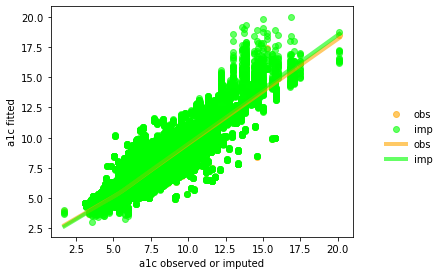

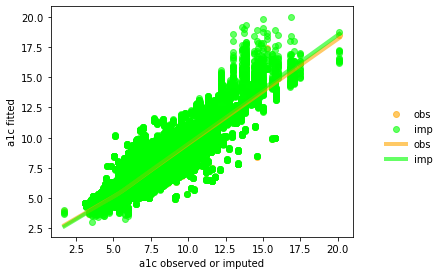

In [13]:
%matplotlib inline
imputedCohort.plot_fit_obs("a1c")

In [14]:
imputedCohort.data.alcoholPerWeek.describe()

count    280786.000000
mean         21.998627
std          80.436783
min           0.000000
25%           0.000000
50%           0.000000
75%           7.000000
max        5228.189941
Name: alcoholPerWeek, dtype: float64

In [15]:
imputedData = imputedCohort.data.copy()

# rebvuild categoricals
imputedData['smokingStatus'] = imputedData[['smoke0', 'smoke1', 'smoke2']].idxmax(axis=1)
imputedData['smokingStatus'] = imputedData['smokingStatus'].str[-1:]
imputedData['raceEthnicity'] = imputedData[['raceEth2', 'raceEth3', 'raceEth4', 'raceEth5']].idxmax(axis=1)
imputedData['raceEthnicity'] = imputedData['raceEthnicity'].str[-1:]

In [16]:
# drop the dummies
imputedData.drop(['smoke0', 'smoke1','smoke2'], axis='columns', inplace=True)
imputedData.drop(['raceEth2', 'raceEth3','raceEth3', 'raceEth4', 'raceEth5'], axis='columns', inplace=True)
imputedData.drop(['educ1', 'educ2','educ3', 'educ4', 'educ5'], axis='columns', inplace=True)
imputedData.drop(list(imputedData.filter(regex='mean')), axis='columns', inplace=True)
# drop the mean variables (they were partially imputed)

In [17]:
# rebuild the mean variables off the impuated values
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi","ldl", "trig", "glucosef",  "waist", "anyPhysicalActivity", "antiHypertensiveCount", "statin", "afib", 'alcoholPerWeek']
logFactorsImputation = ["dbp", "sbp"]

In [18]:
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)

In [19]:
for factor in logFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    logLagName = "log" + newVarName[0].upper() + newVarName[1:]
    logName = "log" + factor[0].upper() + factor[1:]

    imputedData[logName] = np.log(imputedData[factor])  
    imputedData[logLagName] = np.log(imputedData[newVarName])  
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[logLagName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={logLagName + "mean" : 'mean' + logLagName[0].upper() + logLagName[1:]}, inplace=True)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
imputedData.raceEthnicity= imputedData.raceEthnicity.astype('category')
imputedData.smokingStatus= imputedData.smokingStatus.astype('category')
imputedData.sort_values(by=['id', 'age'], inplace=True)

In [21]:
imputedData.raceEthnicity.value_counts()

3    177722
4     61078
2     36458
5      5528
Name: raceEthnicity, dtype: int64

In [22]:
import statsmodels.formula.api as statsmodel
import sys
import os
sys.path.append(os.path.abspath("../mcm/"))
from mcm.regression_model import RegressionModel

regResults = {}

def buildAndExportRegressionModelForDataset(outcomeVariable , fullDataset, hasLog): 
    factors = allFactors.copy()
    factors.extend(logFactors)
    factors.remove(outcomeVariable)
    factors = ["mean" + factor[0].upper() + factor[1:] + " + " + factor + " + " for factor in factors] 
    
    meanLagOutcomeVariable =  "mean" + outcomeVariable[0].upper() + outcomeVariable[1:]
    
    if (not hasLog):
        outcomeVariable = outcomeVariable[3:4].lower() + outcomeVariable[4:] # remove the lag
    else:
        outcomeVariable = "log" + outcomeVariable[-3:] # remove the lag and add the log
    
    formula = outcomeVariable + " ~ " + "".join(factors) + "age + gender + smokingStatus + raceEthnicity + " + meanLagOutcomeVariable

    print("outcome: " + outcomeVariable + " hasLog: " + str(hasLog) + " : " +formula)

    model = statsmodel.ols(formula=formula, data=fullDataset)
    results = model.fit()
    regResults[outcomeVariable] = results
    mcmRegressionModel = RegressionModel(results.params.to_dict(), results.bse.to_dict(), results.resid.mean(), results.resid.std())
    mcmRegressionModel.write_json(os.path.abspath("../mcm/mcm/data/" + outcomeVariable + "CohortModelSpec.json"))
    #results.save("/Users/burke/Documents/research/bpCog/mcm/mcm/data/" + outcomeVariable +  "CohortModel.pickle")
    return results


allFactors = ["lagA1c", "lagHdl", "lagTotChol", "lagBmi", "lagLdl", "lagTrig", "lagWaist", "lagAnyPhysicalActivity", "lagAntiHypertensiveCount", "lagStatin", "lagAfib", 'lagAlcoholPerWeek']
logFactors = ["logLagDbp", "logLagSbp"]

imputedData['logDbp'].loc[imputedData['logDbp'] <= 0] = imputedData['logDbp'].loc[imputedData['logDbp']> 0].min()
imputedData['logLagDbp'].loc[imputedData['logLagDbp'] <= 0] = imputedData['logLagDbp'].loc[imputedData['logLagDbp']> 0].min()
imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp'] <= 0] = imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp']> 0].min()



for factor in allFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, False)
for factor in logFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, True)
    

ModuleNotFoundError: No module named 'mcm'

In [ ]:
imputedData.anyPhysicalActivity.value_counts(normalize=True)

In [ ]:
regResults['logSbp'].summary()

In [ ]:
regResults['afib'].summary()

In [ ]:
regResults['alcoholPerWeek'].summary()

ok...mdels are looking a bit bette rnow. sbp model looks reasonbly close to stata model which is reassureing.

other thought...
if we systematically name the variables here, it may be relatively easy to build a risk model apparatus that reads from these files and implements them. so, "log" means that the predictor is log-transformed. "meanLab" means that you take the maen of all prior values. "lag" means that you take the the value immediately before.

then you can include variable names in snake case — so each variable is multiple in. you'd be able to specify multi-way interactions or quadratic terms pretty easily that way... 